# **TransferLearningDR: EfficientNet-Based Diabetic Retinopathy Detector**

## **Project Overview**

**TransferLearningDR** is a deep learning project designed to detect **Diabetic Retinopathy (DR)** from retinal fundus images, classifying each image as either **DR** or **No DR**.  
The workflow includes **dataset preparation, data augmentation, and transfer learning** with **EfficientNetB3**, followed by deployment as an interactive **Streamlit application** and publishing on **Hugging Face**.

## **Objective**

Build and deploy a reliable **transfer learning model** to support the early detection of **Diabetic Retinopathy**, a diabetes-related eye disease that can cause vision loss if untreated.

## **Dataset**

- **Source**: [Kaggle – Diagnosis of Diabetic Retinopathy Dataset](https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/data)  
- **Classes**: Diabetic Retinopathy (DR), No DR  
- **Preprocessing**: Images resized to **224×224 (RGB)** and normalized  
- Dataset re-split into **train, validation, and test sets** with balanced distributions

## **Modeling Approach**

- **Base Model**: **EfficientNetB3** (pre-trained on ImageNet, fine-tuned for DR classification)  
- **Custom Layers**: Batch normalization, fully connected dense layer, dropout, and final sigmoid output  
- **Training Setup**: Binary crossentropy loss, Adamax optimizer, early stopping, and checkpointing  
- **Augmentation**: Rotation, zoom, brightness adjustment, horizontal flip  

## **Performance**

The final model achieved high performance on the test set:  
- **Accuracy**: `98.2%`  
- **Precision**: `98.6%`  
- **Recall**: `97.9%`  
- **F1 Score**: `98.2%`  

## **Deployment**

- **Streamlit App**: [TransferLearningDR](https://transferlearningdr-httrdrrzqndfzqbyak8wkc.streamlit.app/)  
- **Hugging Face Repo**: [TransferLearningDR](https://huggingface.co/RawanAlwadeya/TransferLearningDR)  

Users can upload retinal fundus images to receive **real-time predictions** indicating whether Diabetic Retinopathy is present.

Watch a short demo of the app here: [View on LinkedIn](https://www.linkedin.com/posts/rawan-alwadeya-17948a305_deeplearning-transferlearning-efficientnet-activity-7373417012628344832-e5pZ?utm_source=share&utm_medium=member_desktop&rcm=ACoAAE3YzG0BAZw48kimDDr_guvq8zXgSjDgk_I)

## **About Diabetic Retinopathy**

<img src="https://cdn.allaboutvision.com/images/diabetic-retinopathy-330x527@2x.jpg" alt="Diabetic Retinopathy" width="700" height="600">

**Diabetic Retinopathy (DR)** is a **diabetes-related eye condition** that harms the **blood vessels in the retina**—the light-sensitive layer at the back of the eye that is essential for clear vision.  

When blood sugar levels remain high for long periods, these tiny blood vessels can **swell, leak fluid, or bleed**, which may cause **blurred vision, dark spots, or even vision loss**.

**Key risk factors** include:  
- Poorly controlled diabetes  
- High blood pressure or high cholesterol  
- Long duration of diabetes  
- Smoking  

Regular **eye examinations** are crucial because **early stages often have no symptoms**.  
With timely medical care—such as **medication, laser treatment, or surgery**—the progression of Diabetic Retinopathy can often be slowed or prevented, helping protect long-term eyesight.

#### **Import Necessary Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import hashlib
import random
from PIL import Image
import itertools
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam , Adamax  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import load_model
from huggingface_hub import login
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
import warnings 
warnings.filterwarnings("ignore")

2025-09-15 09:09:26.899511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757927367.260809      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757927367.366478      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### **Dataset Loading**

In [2]:
base_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy"
splits = ["train", "valid", "test"]

unexpected_files = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for root, _, files in os.walk(split_dir):
        for f in files:
            if not f.lower().endswith(".jpg"):  # all should be .jpg
                unexpected_files.append(os.path.join(root, f))

if unexpected_files:
    print("⚠️ Found unexpected files:")
    for uf in unexpected_files:
        print(uf)
else:
    print("✅ All files are .jpg")

✅ All files are .jpg


In [3]:
def is_image_file(filename):
    return filename.lower().endswith(".jpg")

def build_dataframe(split_name):
    split_dir = os.path.join(base_dir, split_name)
    image_paths = []
    image_labels = []

    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        for image_file in os.listdir(class_path):
            if is_image_file(image_file):
                full_path = os.path.join(class_path, image_file)
                image_paths.append(full_path)
                image_labels.append(class_name)

    return pd.DataFrame({"image_path": image_paths, "label": image_labels})

df_train = build_dataframe("train")
df_val   = build_dataframe("valid")
df_test  = build_dataframe("test")


print(f"✅ Total valid training images: {len(df_train)}")
print(f"✅ Total valid validation images: {len(df_val)}")
print(f"✅ Total valid test images: {len(df_test)}")

df_train.head()

✅ Total valid training images: 2076
✅ Total valid validation images: 531
✅ Total valid test images: 231


,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


In [4]:
df_val.head()

,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


In [5]:
df_test.head()

,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


### **Data Exploration and Visualization**

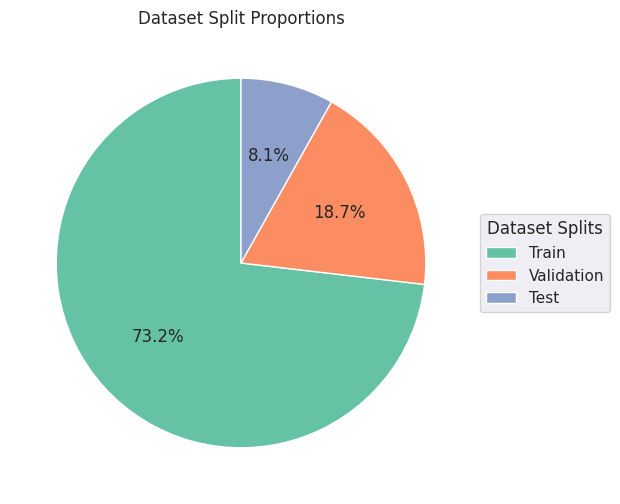

In [6]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys())
sizes = list(split_counts.values())


colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)


plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [7]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

print("✅ Total images:", len(df_all))

✅ Total images: 2838


In [8]:
df_all["label"].value_counts()

label
No_DR    1430
DR       1408
Name: count, dtype: int64

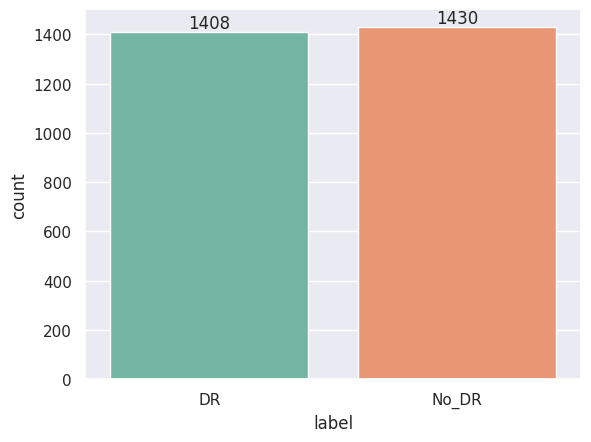

In [9]:
ax = sns.countplot(data=df_all, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

#### **Duplicate Image Detection**

In [10]:
def find_duplicates_in_df(df):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((label, image_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Label", "Duplicate Path", "Original Path"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in dataset")
    return df_duplicates


def display_duplicate_images(df_duplicates, max_samples=5):  
    """Display a few duplicate/original pairs."""
    if df_duplicates.empty:
        print("No duplicates to display.")
        return

    num_samples = min(len(df_duplicates), max_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i, row in enumerate(df_duplicates.iloc[:num_samples].itertuples()):
        try:
            original = Image.open(row._3)  
            duplicate = Image.open(row._2) 

            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original ({row.Label})")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(duplicate, cmap="gray")
            axes[i, 1].set_title("Duplicate")
            axes[i, 1].axis("off")

        except Exception as e:
            print(f"⚠️ Error displaying images: {e}")

    plt.tight_layout()
    plt.show()

In [11]:
df_duplicates = find_duplicates_in_df(df_all)

display_duplicate_images(df_duplicates, max_samples=5)

✅ Found 0 duplicates in dataset
No duplicates to display.


#### **Improving Dataset Splits for Balanced Training**

In [12]:
df_train, df_test = train_test_split(
    df_all,
    test_size=0.1,
    stratify=df_all["label"],
    random_state=42
)


df_train, df_val = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train["label"],
    random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))

Train size: 2298
Val size: 256
Test size: 284


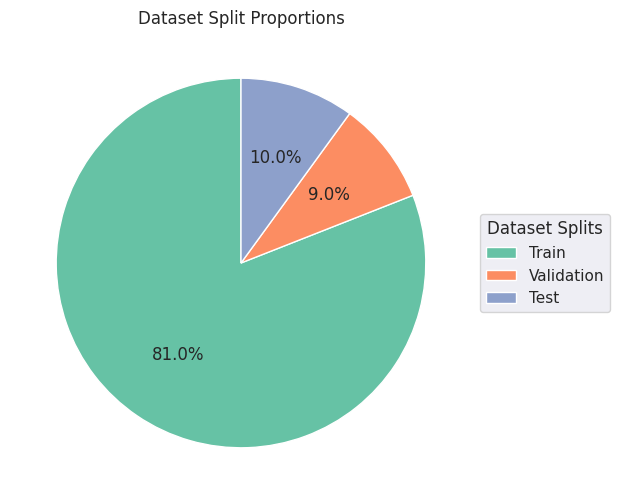

In [13]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys())
sizes = list(split_counts.values())


colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)


plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [14]:
df_splits = pd.DataFrame(list(split_counts.items()), columns=["Split", "Count"])
df_splits

,Split,Count
0,Train,2298
1,Validation,256
2,Test,284


In [15]:
df_train['label'].value_counts()

label
No_DR    1158
DR       1140
Name: count, dtype: int64

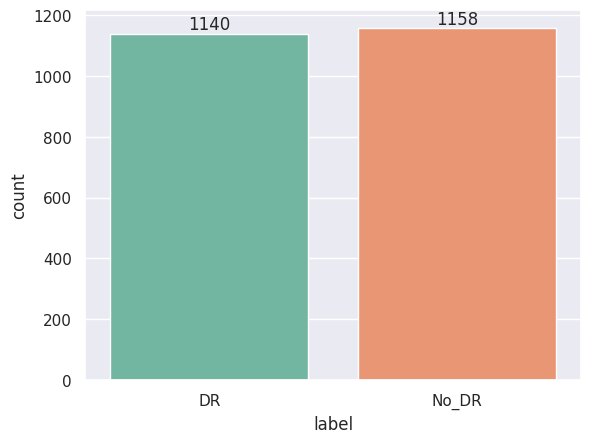

In [16]:
ax = sns.countplot(data=df_train, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

In [17]:
df_val['label'].value_counts()

label
No_DR    129
DR       127
Name: count, dtype: int64

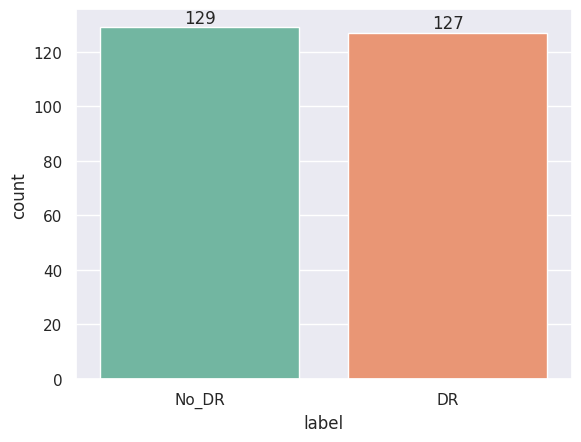

In [18]:
ax = sns.countplot(data=df_val, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

In [19]:
df_test['label'].value_counts()

label
No_DR    143
DR       141
Name: count, dtype: int64

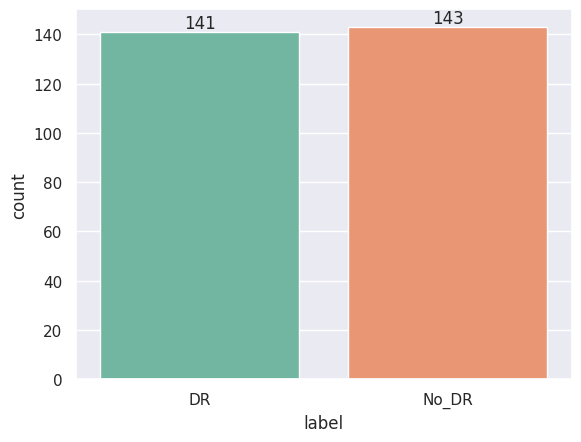

In [20]:
ax = sns.countplot(data=df_test, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

#### **Check for Corrupted Files**

In [21]:
def find_corrupted_images(df):
    corrupted = []

    for row in df.itertuples():
        image_path = row.image_path
        try:
            img = Image.open(image_path)
            img.verify()  # check integrity
        except Exception as e:
            corrupted.append((image_path, str(e)))

    df_corrupted = pd.DataFrame(corrupted, columns=["Image Path", "Error"])
    print(f"✅ Found {len(df_corrupted)} corrupted images")
    return df_corrupted


df_corrupted = find_corrupted_images(df_all)

if not df_corrupted.empty:
    print(df_corrupted.head())
else:
    print("No corrupted images found 🚀")

✅ Found 0 corrupted images
No corrupted images found 🚀


#### **Visualize Sample Images from Each Class**

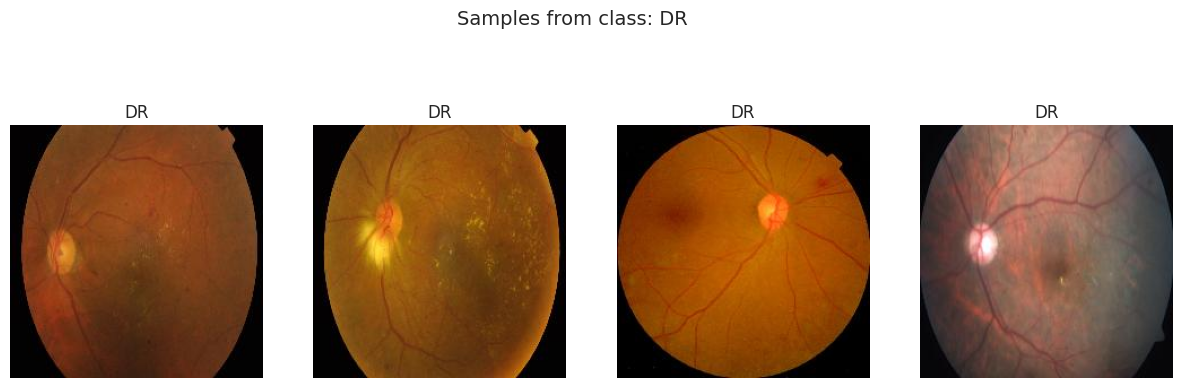

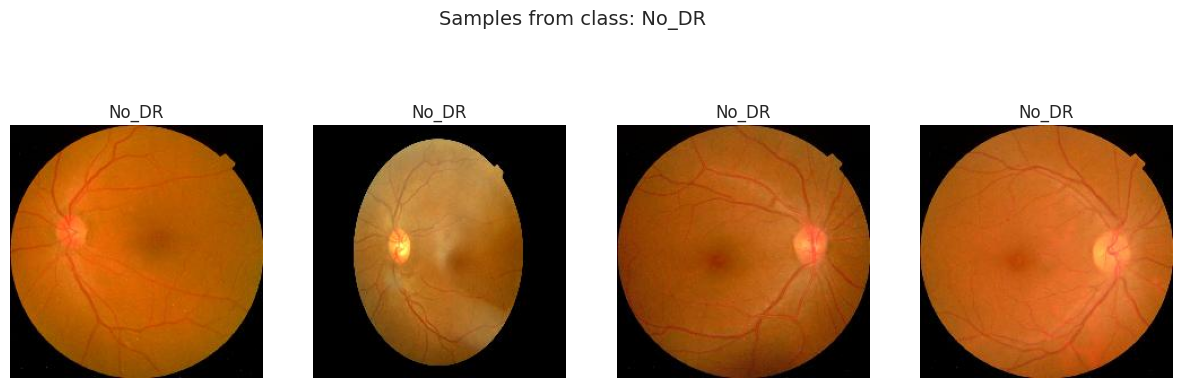

In [22]:
def show_class_samples(df, class_name, n_samples=4):
    """Display n_samples images from a given class."""
    sample_df = df[df["label"] == class_name].sample(n_samples, random_state=42)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(f"Samples from class: {class_name}", fontsize=14)

    for i, row in enumerate(sample_df.itertuples()):
        img = Image.open(row.image_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")

    plt.show()


show_class_samples(df_all, "DR", n_samples=4)
show_class_samples(df_all, "No_DR", n_samples=4)

#### **Image Data Augmentation and Visualization**

In [23]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32

train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=1,           
    zoom_range=0.1,              
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,        
    fill_mode="nearest" 
)

val_test_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",  
    class_mode="binary",
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)

val_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 2298 validated image filenames belonging to 2 classes.
Found 256 validated image filenames belonging to 2 classes.
Found 284 validated image filenames belonging to 2 classes.


In [24]:
print("Train class indices:", train_generator.class_indices)
print("Val class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'DR': 0, 'No_DR': 1}
Val class indices: {'DR': 0, 'No_DR': 1}
Test class indices: {'DR': 0, 'No_DR': 1}


### **Training EfficientNetB3 for Diabetic Retinopathy Detection**

#### **About EfficientNetB3**
EfficientNetB3 is part of the EfficientNet family of convolutional neural networks. It uses **compound scaling** to balance depth, width, and resolution for optimal performance.  
The network is pretrained on **ImageNet**, enabling **transfer learning** to medical images. Its architecture combines **convolutional layers, MBConv blocks, and squeeze-and-excitation layers** for efficient feature extraction.  
The `include_top=False` setting removes the final classification layer so we can add a **custom head** for our binary classification task.

#### **Why Transfer Learning?**
Training deep models from scratch requires very large datasets and high compute power.  
**Transfer learning** leverages **knowledge from large-scale datasets (like ImageNet)** and adapts it to new tasks with limited data.  
For medical imaging, this approach improves **accuracy, generalization, and training efficiency**.

<img height=1200 width=1000 src="https://www.researchgate.net/publication/359449935/figure/fig2/AS:1179981350744115@1658340885857/Schematic-representation-of-EfficientNet-B3.png" />

In [33]:
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
 

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling="max"
)


model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,
          kernel_regularizer=regularizers.l2(0.001),
          activity_regularizer=regularizers.l1(0.0001),
          bias_regularizer=regularizers.l1(0.00001),
          activation="relu"),
    Dropout(0.45, seed=42),
    Dense(1, activation="sigmoid")  
])


model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,408 (42.66 MB)

 Trainable params: 11,093,033 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [34]:
early_stopping = callbacks.EarlyStopping(
    patience=10,          
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",      
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [35]:
EPOCHS = 5

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8671 - loss: 1.2221
Epoch 1: val_accuracy improved from -inf to 0.94922, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.8679 - loss: 1.2197 - val_accuracy: 0.9492 - val_loss: 1.0041
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9646 - loss: 0.7741
Epoch 2: val_accuracy improved from 0.94922 to 0.97656, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 463ms/step - accuracy: 0.9646 - loss: 0.7734 - val_accuracy: 0.9766 - val_loss: 0.6758
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9769 - loss: 0.6311
Epoch 3: val_accuracy improved from 0.97656 to 0.98438, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 463ms/step - accuracy: 0.9769 - loss: 0.6308 - val_accuracy: 0.9844 - val_loss: 0.5832
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9771 - loss: 0.5854
Epoch 4: val_accuracy improved from 0.98438 to 0.98828, 

#### **Model Evalution**

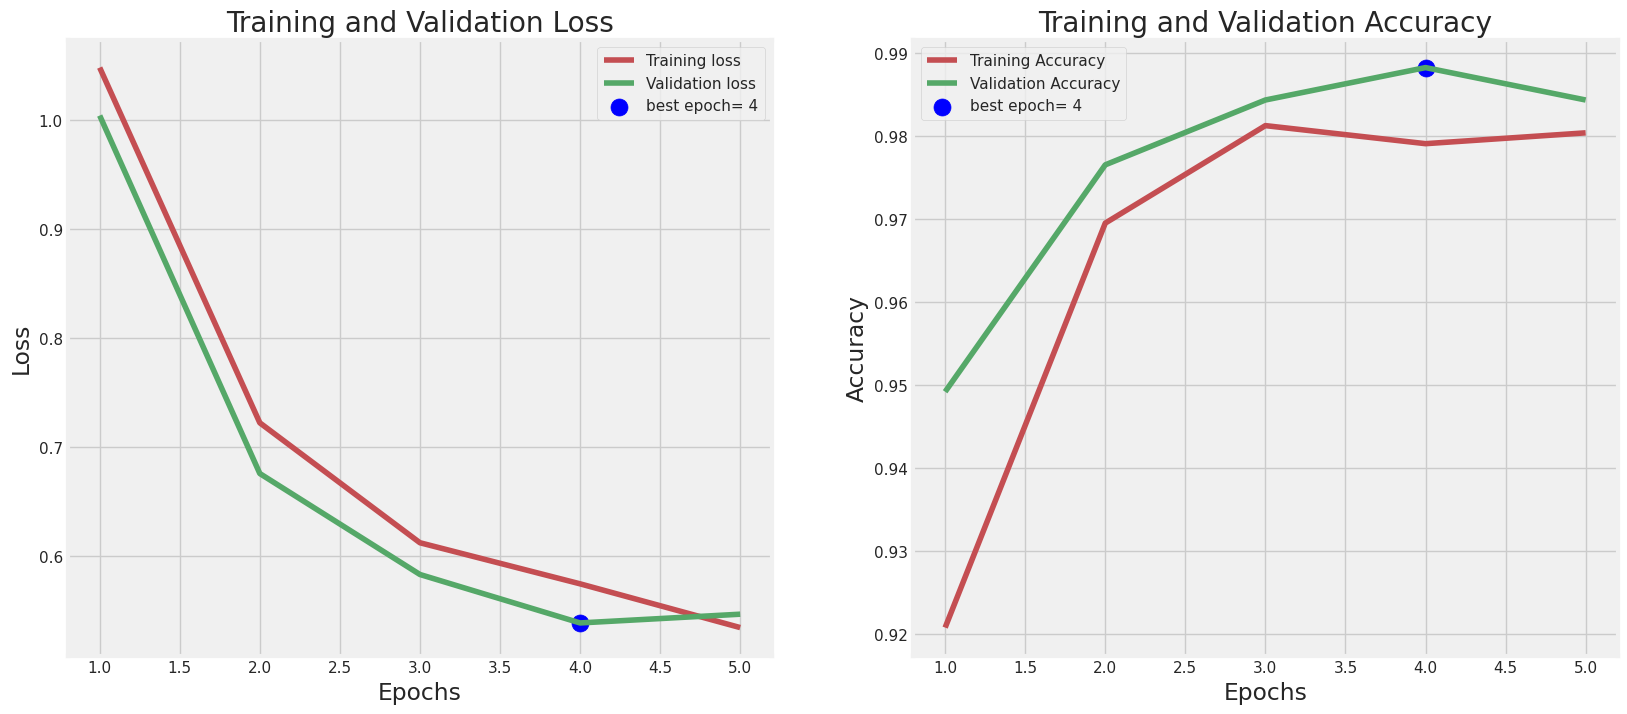

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [37]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("\nTrain Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - accuracy: 0.9911 - loss: 0.5283
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9934 - loss: 0.5295
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9749 - loss: 0.5877  

Train Loss:  0.5319340229034424
Train Accuracy:  0.9895561337471008
--------------------
Validation Loss:  0.5387149453163147
Validation Accuracy:  0.98828125
--------------------
Test Loss:  0.5803874135017395
Test Accuracy:  0.9823943376541138


In [38]:
y_pred_prob = model.predict(test_generator)
y_pred_prob

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


array([[0.01424941],
       [0.992581  ],
       [0.0387134 ],
       [0.00285568],
       [0.98878443],
       [0.03899937],
       [0.00647624],
       [0.00541877],
       [0.9938199 ],
       [0.02169046],
       [0.9915837 ],
       [0.2748807 ],
       [0.9921997 ],
       [0.9861458 ],
       [0.9936055 ],
       [0.9903527 ],
       [0.0183225 ],
       [0.99786085],
       [0.65897346],
       [0.9634708 ],
       [0.9943402 ],
       [0.9709698 ],
       [0.00893607],
       [0.00305745],
       [0.99510455],
       [0.99742246],
       [0.00839307],
       [0.00332984],
       [0.00928772],
       [0.00630686],
       [0.00476193],
       [0.00871046],
       [0.02028183],
       [0.994344  ],
       [0.01064996],
       [0.9795701 ],
       [0.96000314],
       [0.9664175 ],
       [0.01760067],
       [0.9969723 ],
       [0.02949256],
       [0.94252235],
       [0.9960121 ],
       [0.01778999],
       [0.9825867 ],
       [0.00632535],
       [0.02698795],
       [0.982

In [39]:
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()
y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [40]:
y_true = test_generator.classes
y_true

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,


In [41]:
CM = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", CM)

Confusion Matrix:
 [[139   2]
 [  3 140]]


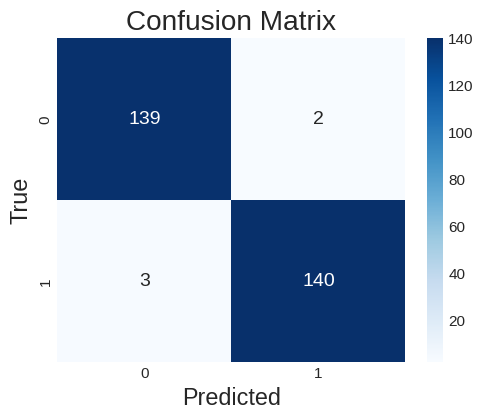

In [42]:
plt.style.use("seaborn-white")
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [43]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


Classification Report:
              precision    recall  f1-score   support

          DR       0.98      0.99      0.98       141
       No_DR       0.99      0.98      0.98       143

    accuracy                           0.98       284
   macro avg       0.98      0.98      0.98       284
weighted avg       0.98      0.98      0.98       284



In [44]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9824
Precision: 0.9859
Recall:    0.9790
F1 Score:  0.9825


In [45]:
images, labels = next(test_generator)

image = images[0]
true_label = labels[0]

pred = model.predict(np.expand_dims(image, axis=0))

prob = pred[0][0]
predicted_class = 1 if prob >= 0.5 else 0

print("Probability:", prob)
print("Predicted Class:", predicted_class)
print("True Label:", true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Probability: 0.014249407
Predicted Class: 0
True Label: 0.0


#### **Authenticate with Hugging Face Hub**

In [ ]:
load_dotenv()

token = os.getenv("HUGGINGFACE_TOKEN")

login(token=token)

In [48]:
api = HfApi()

repo_id = "RawanAlwadeya/TransferLearningDR"

api.create_repo(repo_id=repo_id, repo_type="model", private=False, exist_ok=True)

print(f"Repo created: https://huggingface.co/{repo_id}")

local_model_path = "/kaggle/working/best_model.h5"

api.upload_file(
    path_or_fileobj=local_model_path,
    path_in_repo="TransferLearningDR.h5",   
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded to: https://huggingface.co/{repo_id}/blob/main/TransferLearningDR.h5")

Repo created: https://huggingface.co/RawanAlwadeya/TransferLearningDR


Uploading...:   0%|          | 0.00/135M [00:00<?, ?B/s]

Model uploaded to: https://huggingface.co/RawanAlwadeya/TransferLearningDR/blob/main/TransferLearningDR.h5


#### **Load and Test Model from Hugging Face Hub**

In [3]:
model_path = hf_hub_download(
    repo_id="RawanAlwadeya/TransferLearningDR", 
    filename="TransferLearningDR.h5"  
)

model = load_model(model_path)
print("✅ Model loaded from Hugging Face:", model_path)

TransferLearningDR.h5:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ Model loaded from Hugging Face: C:\Users\OMEN\.cache\huggingface\hub\models--RawanAlwadeya--TransferLearningDR\snapshots\28b4889b55eed28e0f0e98b4c7aa7cf28c900816\TransferLearningDR.h5


In [10]:
def preprocess_image(image_path):
    IMG_SIZE = (224, 224)
    image = Image.open(image_path).convert("RGB")
    image = image.resize(IMG_SIZE)
    img_array = np.array(image)
    img_array = preprocess_input(img_array)       
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array


def predict_and_show(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)[0][0]
    

    if prediction < 0.5:
        label = "⚠️ Diabetic Retinopathy likely detected"
    else:
        label = "✅ Likely No Diabetic Retinopathy" 

    
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.show()
    
    print(f"Probability: {prediction:.4f} | {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


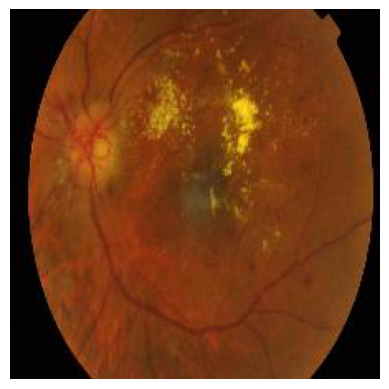

Probability: 0.0745 | ⚠️ Diabetic Retinopathy likely detected


In [11]:
predict_and_show("DR.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


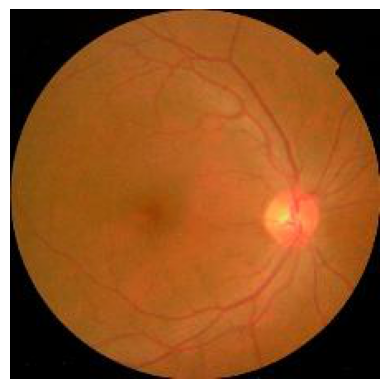

Probability: 0.9949 | ✅ Likely No Diabetic Retinopathy


In [12]:
predict_and_show("No_DR.jpg")

## **Final Thoughts**

This project demonstrates the effectiveness of **transfer learning** in detecting **Diabetic Retinopathy (DR)** from retinal fundus images.  
By combining **EfficientNetB3’s powerful feature extraction** with a carefully prepared dataset—including **balanced re-splitting, exploratory analysis, and data augmentation**—the model achieved **exceptional accuracy, precision, and recall**, ensuring reliable classification between **DR** and **No DR**.

Key regularization strategies such as **early stopping** and **model checkpointing** helped prevent overfitting while preserving the model’s ability to generalize across new images.  
The EfficientNet architecture, pre-trained on ImageNet, provided a strong foundation for transfer learning, allowing the model to capture fine-grained retinal features critical for early DR detection.

Deployment to both a **Streamlit web application** and **Hugging Face Spaces** transforms this work into an accessible, real-time screening tool.  
Such AI-driven solutions can support **clinicians and healthcare workers**, offering rapid, accurate assessments that complement professional medical evaluation.

---

**Thank you for exploring the TransferLearningDR project.**